In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [234]:
# Get targets data
sample_data = pd.read_csv("221201_big_requests.csv").dropna()
targets = sample_data["target_host"]

In [ ]:
# Filtering valid targets
import requests

for target in targets['target_host']:
    try:
        response = requests.get(target)
        if response.status_code == 200:
            targets.loc[targets["target_host"] == target, 'valid'] = True
        else:
            targets.loc[targets["target_host"] == target, 'valid'] = False
    except:
        pass


targets = pd.DataFrame(sample_data["target_host"]).drop_duplicates()
targets['target_host'] = "http://" + targets['target_host'] # daryti atskirą column
targets['valid'] = ""

targets.to_csv("targets_valid.csv")

In [177]:
# Filtering valid targets
targets = pd.read_csv('targets_valid.csv')
targets['target_host'] = targets['target_host'].str.replace("http://","")
sample_data = sample_data.merge(targets, how = "inner", on = "target_host")
sample_data = sample_data[sample_data["valid"] == True]

In [235]:
sample_data = sample_data.pivot(index = ["account_id", "vertical"], columns = "target_host", values = "share",).fillna(0)
sample_data.reset_index(inplace = True)
samples = sample_data.drop(columns=["account_id", "vertical"]).values

In [229]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(samples)
StandardScaler(copy=True, with_mean=True, with_std=True)
features_scaled = scaler.transform(samples)

In [236]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(samples)
features_normalized = normalizer.transform(samples)

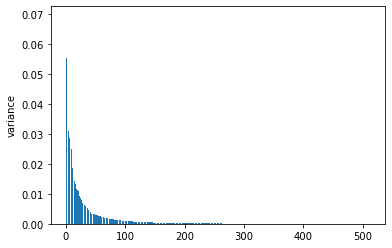

In [187]:
# Intrinsic dimension

model = PCA()
model.fit_transform(features_normalized)

features = range(model.n_components_)
# features = range(0, 1000)

plt.bar(features, model.explained_variance_)
# plt.xticks(features)
plt.ylabel('variance')
plt.show()

In [198]:
model = PCA(n_components=150)
model.fit(samples)
transformed = model.transform(samples)

In [231]:
clusters = np.arange(1, 25)
model_inertias = []

for cluster in clusters:
	model = KMeans(n_clusters=cluster)
	model.fit(features_scaled)
	model_inertias.append(model.inertia_)

In [65]:
model_inertias[12]

4640.157236885483

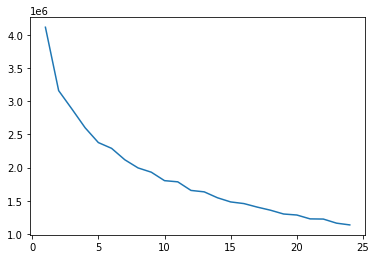

In [232]:
plt.plot(clusters, model_inertias)

In [201]:
model = KMeans(n_clusters=12)
# labels = model.fit_predict(samples)
# labels = model.fit_predict(transformed)
labels = model.fit_predict(features_normalized)
# labels = model.fit_predict(features_scaled)
sample_data["label"] = labels

In [239]:
# test

model = KMeans(n_clusters=12)
labels = model.fit_predict(features_normalized)
sample_data["label"] = labels
sample_data["label"].value_counts()

2     2983
4     1895
8      520
6      494
9      472
1      414
11     251
3      230
10     224
7      219
5      200
0      115
Name: label, dtype: int64

In [204]:
# valid normalized

model = KMeans(n_clusters=12)
labels = model.fit_predict(features_normalized)
sample_data["label"] = labels
sample_data["label"].value_counts()

0     2765
3     1098
9      813
8      572
1      554
2      497
6      453
4      390
11     276
5      255
7      201
10     143
Name: label, dtype: int64

In [97]:
# requests normalized
sample_data["label"].value_counts()

4     2965
3     1273
7      730
8      546
6      518
5      469
2      410
10     240
9      228
0      220
11     218
1      200
Name: label, dtype: int64

In [84]:
# traffic share normalized
sample_data["label"].value_counts()

10    3323
3     1133
2      557
4      541
6      485
1      434
5      325
0      304
11     259
9      255
8      204
7      197
Name: label, dtype: int64

In [78]:
# traffic share
sample_data["label"].value_counts()

7     5304
0      494
3      425
2      392
5      371
6      178
11     177
1      176
4      176
9      120
8      103
10     101
Name: label, dtype: int64

In [63]:
# traffic normalized
sample_data["label"].value_counts()

1     3420
5     1120
4      557
8      549
6      484
0      434
10     324
3      308
7      260
9      252
11     197
2      112
Name: label, dtype: int64

In [91]:
# requests share normalized
sample_data["label"].value_counts()

1     3287
7     1346
5      706
0      555
3      523
9      469
2      241
8      224
10     220
11     204
6      169
4       73
Name: label, dtype: int64

In [87]:
# requests share
sample_data["label"].value_counts()

2     5937
3      404
5      388
10     269
0      177
7      171
8      150
6      144
9      123
1       97
4       79
11      78
Name: label, dtype: int64

In [258]:
targets_by_category = pd.DataFrame()

for label in sample_data["label"].unique():
    sample_n = sample_data[sample_data["label"] == label]
    sams_unpivoted = sample_n.drop("label", axis = 1).melt(id_vars=['account_id', 'vertical'], var_name='target_host', value_name='requests')
    # targets_sorted = sams_unpivoted.groupby("target_host").agg({"requests":"sum"}).sort_values("requests", ascending=False).index
    targets_sorted = sams_unpivoted[sams_unpivoted["requests"] > 0].groupby("target_host").agg({"requests":"count"}).sort_values("requests", ascending=False).index
    targets_by_category[label]=targets_sorted[1:100]

targets_by_category


,4,6,2,8,9,1,0,7,10,5,3,11
0,gstatic.com,fbcdn.net,google-analytics.com,gstatic.com,facebook.com,mozilla.org,px-cloud.net,go-mpulse.net,smartproxy.com,gstatic.com,doubleclick.net,cloudflare.com
1,doubleclick.net,doubleclick.net,doubleclick.net,doubleclick.net,gstatic.com,mozilla.net,doubleclick.net,nikecdn.com,gstatic.com,google-analytics.com,gstatic.com,gstatic.com
2,googletagmanager.com,gstatic.com,googletagmanager.com,google-analytics.com,fbcdn.net,digicert.com,googleadservices.com,newrelic.com,google-analytics.com,fonts.googleapis.com,facebook.com,content-autofill.googleapis.com
3,fonts.googleapis.com,content-autofill.googleapis.com,fonts.googleapis.com,fonts.googleapis.com,facebook.net,lencr.org,bing.com,forter.com,googletagmanager.com,doubleclick.net,amazonaws.com,doubleclick.net
4,facebook.com,google-analytics.com,facebook.com,googletagmanager.com,cdninstagram.com,pki.goog,googletagmanager.com,content-autofill.googleapis.com,doubleclick.net,content-autofill.googleapis.com,demdex.net,facebook.com
...,...,...,...,...,...,...,...,...,...,...,...,...
94,moatads.com,disqus.com,1rx.io,360yield.com,stackadapt.com,yimg.com,optimizely.com,google.com,livechatinc.com,lijit.com,advertising.com,stickyadstv.com
95,ipredictive.com,t.co,360yield.com,creativecdn.com,pinterest.com,360yield.com,zemanta.com,smaato.net,moatads.com,hcaptcha.com,jsdelivr.net,quantcount.com
96,akamaihd.net,adsafeprotected.com,live.com,rfihub.com,akamaihd.net,vk.com,reddit.com,ipinfo.io,3lift.com,pki.goog,skype.com,media.net
97,unrulymedia.com,addthis.com,spotxchange.com,googlevideo.com,gumgum.com,tapad.com,tremorhub.com,safebrowsing.googleapis.com,outbrain.com,openstreetmap.org,smartadserver.com,tribalfusion.com


In [260]:
targets_by_category.to_csv('221202_targets_count_by_category_targets_normalized.csv')